<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Случайный-лес-с-Pipeline" data-toc-modified-id="Случайный-лес-с-Pipeline-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес с Pipeline</a></span></li><li><span><a href="#Оценка-модели-на-тестовой-выборке" data-toc-modified-id="Оценка-модели-на-тестовой-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Оценка модели на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from tqdm import tqdm
from random import sample
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV,
    cross_val_score,
    KFold
)
import re
from sklearn.utils import shuffle
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from scipy.stats import randint as sp_randInt
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Оценим баланс классов:

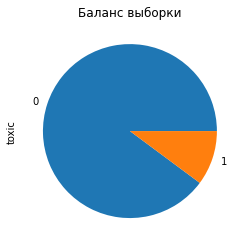

In [7]:
df.groupby(by='toxic')['toxic'].count().plot(kind='pie').set_title('Баланс выборки');

In [8]:
df['toxic'].sum()

16186

Удалим паразитный столбцец и произведем Downsampling нулевого класса.

In [9]:
df = df.drop('Unnamed: 0', axis=1)

Создадим функции лемматизации и сопоставления POS-тега

In [10]:
wnl = WordNetLemmatizer()

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join((re.sub(r'[^a-zA-Z ]', ' ', 
                                         str([wnl.lemmatize(w, get_wordnet_pos(w)) for w in word_list]))).split())
        
    return lemmatized_output

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Лемматизируем созданный корпус слов 

In [12]:
df['text'] = df['text'].str.lower()

In [13]:
tqdm.pandas()
df['lemm'] = df['text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [25:38<00:00, 103.51it/s]


Разделим датафрейм на на тренировочную и тестовые выборки

In [15]:
features = df.drop('toxic', axis=1)
target = df['toxic']

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.10, random_state=12345)

In [17]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(143362, 2)

(15930, 2)

(143362,)

(15930,)

Используем TF-IDF для обработки данных, а так же отфильтруем содержимое при помощи библиотеки nltk, загрузив библиотеку и стоп-слова из английского языка, применив модель TfidfVectorizer и обучив её на тренировочных данных

In [20]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
tf_idf = count_tf_idf.fit_transform(features_train['lemm'])

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


__Вывод__

Ознакомление с данными показало дисбаланс классов, наличие не имеющих полезности для моделей столбца, необходимость лемматизации данных, в связи с чем были произведены необходимые процедуры.

## Обучение

Обучим модели Логистической регрессии, CatBoost и случайного леса, определив оптимальные гиперпараметры.

### Логистическая регрессия

In [21]:
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10000, C=12)

In [22]:
model_log.fit(tf_idf, target_train)

LogisticRegression(C=12, max_iter=10000, random_state=12345)

In [23]:
scores_list = cross_val_score(estimator=model_log, 
                              X=tf_idf, 
                              y=target_train, 
                              scoring='f1')
val_score = scores_list.mean()
print("f1:\n", val_score)

f1:
 0.766087785885633


### CatBoost

In [24]:
model_cat = CatBoostClassifier(random_state=12345)
parameters = {'iterations' : sp_randInt(5, 20),
              'depth' : sp_randInt(2, 4),
             }
randm_src_cat = RandomizedSearchCV(estimator=model_cat, param_distributions=parameters, 
                                      n_iter=10, scoring='f1', n_jobs=-1)
randm_src_cat.fit(tf_idf, target_train)
print("Лучшая f1:\n", abs(randm_src_cat.best_score_))

Learning rate set to 0.5
0:	learn: 0.3531594	total: 900ms	remaining: 9s
1:	learn: 0.2770196	total: 1.74s	remaining: 7.83s
2:	learn: 0.2506461	total: 2.61s	remaining: 6.96s
3:	learn: 0.2391099	total: 3.44s	remaining: 6.02s
4:	learn: 0.2315284	total: 4.26s	remaining: 5.11s
5:	learn: 0.2266445	total: 5.07s	remaining: 4.22s
6:	learn: 0.2188333	total: 5.91s	remaining: 3.38s
7:	learn: 0.2147636	total: 6.78s	remaining: 2.54s
8:	learn: 0.2108932	total: 7.58s	remaining: 1.68s
9:	learn: 0.2079104	total: 8.39s	remaining: 839ms
10:	learn: 0.2050302	total: 9.2s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3526949	total: 865ms	remaining: 8.64s
1:	learn: 0.2759354	total: 1.73s	remaining: 7.78s
2:	learn: 0.2498863	total: 2.57s	remaining: 6.86s
3:	learn: 0.2387180	total: 3.38s	remaining: 5.92s
4:	learn: 0.2310756	total: 4.21s	remaining: 5.05s
5:	learn: 0.2231241	total: 5.06s	remaining: 4.21s
6:	learn: 0.2183635	total: 5.96s	remaining: 3.4s
7:	learn: 0.2136618	total: 6.79s	remaining: 2.55s
8:	lea

### Случайный лес с Pipeline

In [25]:
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=12345), 
                              RandomForestClassifier())
params = {
    'n_estimators' : sp_randInt(10, 300),
    'max_depth'    : sp_randInt(2, 30),
    'random_state': [12345],
    'criterion': ['entropy']
}

In [26]:
kf = KFold(n_splits=2, random_state=12345, shuffle=True)

In [27]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
randm_src_forest = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, scoring='f1', cv=kf, n_jobs=-1)
randm_src_forest.fit(tf_idf, target_train)
print("Лучшая модель:\n", randm_src_forest.best_estimator_)
print("Лучшая f1:\n", abs(randm_src_forest.best_score_))

Лучшая модель:
 Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=12345)),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=28,
                                        n_estimators=282,
                                        random_state=12345))])
Лучшая f1:
 0.42579989013042874


__Вывод__



Лучшие результаты были получены на модели логистической регрессии, f1=0.76 на кросс-валидации. Оценим ее качество на тестовой выборке.

### Оценка модели на тестовой выборке

Создадим корпус тестовой лемматизированной выборки и расчитаем TF-IDF.

In [28]:
tfidf_test = count_tf_idf.transform(features_test['lemm'])

In [29]:
%time predict_log = model_log.predict(tfidf_test)

CPU times: user 4.03 ms, sys: 585 µs, total: 4.62 ms
Wall time: 3.14 ms


Оценим качество предсказаний моделей по f1 метрике.

In [30]:
print('f1 LogisticRegression', f1_score(target_test, predict_log))

f1 LogisticRegression 0.778705636743215


__Вывод__

Из рассматриваемых моделей - модель Логистической регрессии значительно лучше справилась с поставленной задачей и прошла порог f1=0.75. 

## Выводы

В данной работе было необходимо найти и обучить модель для магазина "ВИКИШОП", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по метрике F1 > 0.75.

Была произведена предобработка данных было определено, что изначально в данных сильный дисбаланс классов.

Для определения наилучшей модели мы остановили наш выбор на трёх моделях CatBoostClassifier, LogisticRegression и RandomForestClassifier. Лучшие результаты показала модель LogisticRegression с результатом F1 = 0.778 на тестовой выборке.

Для модели случайного леса произвели балансировку внутри Pipeline.